In [94]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [95]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
df = train.append(test)
df.set_index('id',inplace=True)
df.head(2)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
id,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331


# EDA
---

There some variables correlated but any of them above 0.9 for other we can deal with it using l1 or l2 penalty

In [96]:
corr_analysis = pd.melt(df.corr(),var_name='variable2',value_name='corr',ignore_index=False).reset_index().rename(columns={'index':'variable1'})
corr_analysis.query('variable1 != variable2',inplace=True)
corr_analysis['corrabs'] = corr_analysis['corr'].abs()
corr_analysis['varTuple'] = corr_analysis.apply(lambda x: str(sorted([x['variable1'],x['variable2']])),axis=1)
corr_analysis.drop_duplicates(["varTuple"],inplace=True)
corr_analysis.sort_values("corrabs").tail(7)

,variable1,variable2,corr,corrabs,varTuple
129,cont10,cont9,0.725733,0.725733,"['cont10', 'cont9']"
85,cont11,cont6,0.737542,0.737542,"['cont11', 'cont6']"
86,cont12,cont6,0.756768,0.756768,"['cont12', 'cont6']"
84,cont10,cont6,0.771422,0.771422,"['cont10', 'cont6']"
87,cont13,cont6,0.784373,0.784373,"['cont13', 'cont6']"
8,cont9,cont1,0.793965,0.793965,"['cont1', 'cont9']"
161,cont12,cont11,0.825740,0.825740,"['cont11', 'cont12']"


# Model Development

---



## Feature Engineering 1

In [4]:
initial_cols = df.columns.drop('target')

### Multiplied Features

In [5]:
initial_cols = df.columns.drop('target')
from itertools import combinations

possible_features = [[x,y] for x,y in combinations(df.drop('target',axis=1).columns,2)]
for x,y in combinations(df.drop('target',axis=1).columns,2):
    df[f"{x}_{y}"] = df[x]*df[y]

### Polynomial Features

In [6]:
# for col in initial_cols:
#     df[f"{col}_power2"] = df[col]**2
#     df[f"{col}_power3"] = df[col]**3

## Dataset Size Reduction

In [111]:
for col in df.columns:
    df[col] = df[col].astype('float32')

## Data Split

In [120]:
train = df.dropna()
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
cv = KFold(2,shuffle=True,random_state=42)
x = train.drop('target',axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

## Feature Selection

### Univariate Tests

In [99]:
from sklearn.feature_selection import f_regression,mutual_info_regression

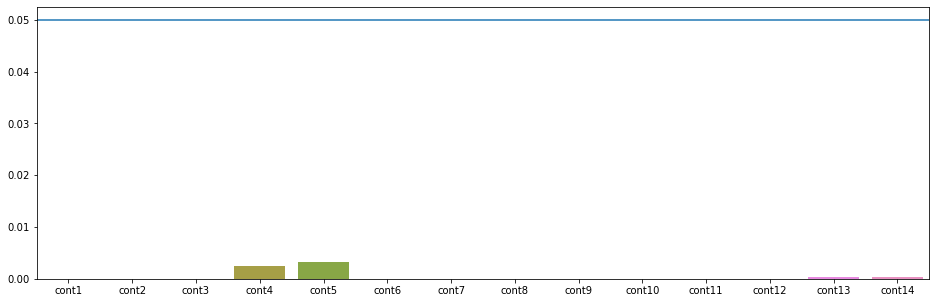

In [107]:
#f_reg = f_regression(x,y)
plt.figure(figsize=(16,5))
plt.axhline(0.05)
sns.barplot(x.columns,f_reg[1])

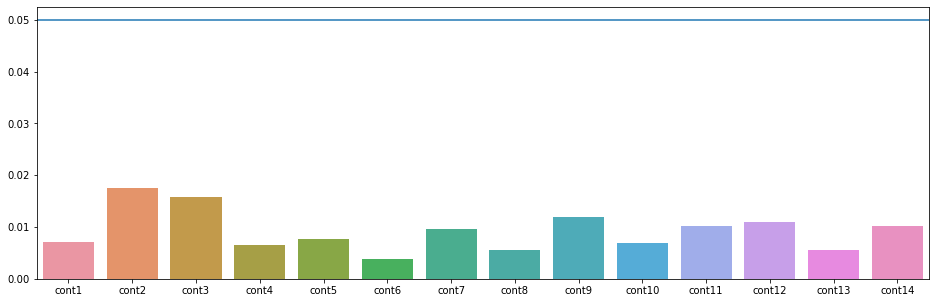

In [110]:
#mutual_test = mutual_info_regression(x,y)
mutual_test
plt.figure(figsize=(16,5))
plt.axhline(0.05)
sns.barplot(x.columns,mutual_test)

### PCA

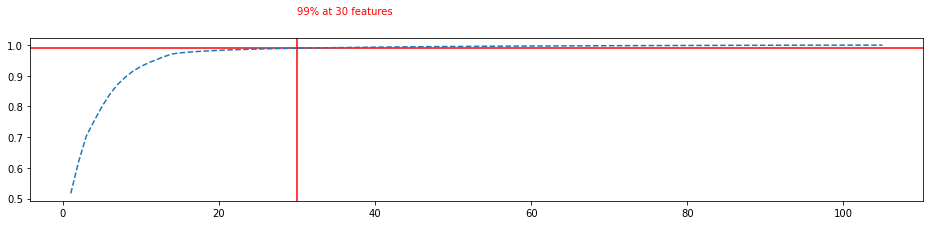

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df.drop('target',axis=1))
exp_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(16,3))
plt.axhline(0.99,color='r')

exp_99 = exp_var[exp_var < 0.99].shape[0]
plt.axvline(exp_99,color='r')
plt.text(exp_99,1.1,f"99% at {exp_99} features",color='r')

plt.plot(range(1,len(exp_var)+1),exp_var,'--')

In [9]:
print(f"Reducing to 99% explained variance {exp_99} features")
pca = PCA(n_components=exp_99)
df_pca = pca.fit_transform(df.drop('target',axis=1))

df_pca = pd.DataFrame(df_pca,index=df.index)
df_pca.columns = [f"PCAcont{col+1}"for col in df_pca.columns]
df_pca['target'] = df['target']
df = df_pca
df.head(2)

Reducing to 99% explained variance 30 features


,PCAcont1,PCAcont2,PCAcont3,PCAcont4,PCAcont5,PCAcont6,PCAcont7,PCAcont8,PCAcont9,PCAcont10,...,PCAcont22,PCAcont23,PCAcont24,PCAcont25,PCAcont26,PCAcont27,PCAcont28,PCAcont29,PCAcont30,target
id,,,,,,,,,,,,,,,,,,,,,
1,1.765131,1.660926,-0.727509,0.274849,0.285394,-0.075425,-0.608382,-0.342790,0.118588,-0.180809,...,-0.054493,-0.127485,-0.022679,-0.087776,-0.008314,-0.039625,-0.082870,0.015646,0.019230,7.243042
3,-0.591978,0.304501,0.378540,0.283033,0.084606,-0.060904,0.207874,0.137612,-0.052794,-0.049525,...,-0.024789,-0.002509,-0.046507,0.004449,-0.005307,-0.017958,-0.009525,-0.013994,-0.002168,8.203331


## Cross Validation

We gonna apply Kfold as our CV strategy 

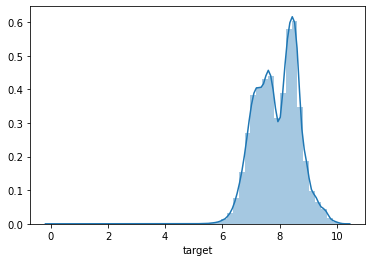

In [42]:
sns.distplot(y)
percentile_limits = y.quantile(q=[0.01,0.99]).to_list()
train.query(f"target >={percentile_limits[0]} and target <= {percentile_limits[1]}",inplace=True)

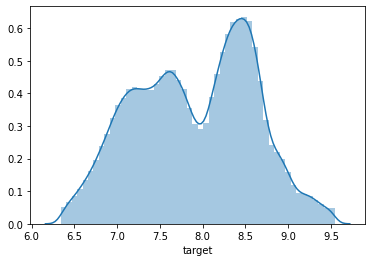

In [46]:
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()
#sns.distplot(y_scaler.fit_transform(np.array(y).reshape(-1, 1)))
sns.distplot(y)

## Hyperparameter Tunning

In [122]:
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.metrics import make_scorer,mean_squared_error
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [123]:
params_dict = {
    "ElasticNet":{
        'alpha':[0,0.1,0.5,0.9,1],
        'l1_ratio':[0,0.1,0.5,0.9,1],
    },
    "DecisionTreeRegressor":{
        'max_depth':[3,10,40,None],
        'min_samples_split':[2,50,300]
    },
    "RandomForestRegressor":{
        "n_estimators":[10,40,70],
        'max_depth':[3,7,21,None],
        
    },
    "MLPRegressor":{
        'activation':['relu'],
        "hidden_layer_sizes":[(100,),(40,),(300)],
        "alpha":[0.01,0.001],
        "early_stopping":[True]
    },
    "HistGradientBoostingRegressor":{
        "l2_regularization":10. ** (-np.arange(1,3)),
        "max_iter":[10,30,100,300],
        "learning_rate":10. ** (-np.arange(1,3))
    },
    "AdaBoostRegressor":{
        "n_estimators":[3,10,50],
    },
    "GaussianProcessRegressor":{
        "alpha":10. ** (-np.arange(8,10)),
    },
    "KNeighborsRegressor":{
        "n_neighbors":[3,5,7],
        "weights":['uniform','distance']
    }
}

model_dict = {
    "ElasticNet":GridSearchCV(ElasticNet(random_state=42),param_grid=""),
    "DecisionTreeRegressor":GridSearchCV(DecisionTreeRegressor(random_state=42),param_grid=""),
    "RandomForestRegressor":GridSearchCV(RandomForestRegressor(random_state=42),param_grid=""),
    "MLPRegressor":GridSearchCV(MLPRegressor(random_state=42),param_grid=""),
    "HistGradientBoostingRegressor":GridSearchCV(HistGradientBoostingRegressor(random_state=42),param_grid=""),
    "AdaBoostRegressor":GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=None),random_state=42),param_grid=""),
    #"GaussianProcessRegressor":GridSearchCV(GaussianProcessRegressor(random_state=42),param_grid=""),
    "KNeighborsRegressor":GridSearchCV(KNeighborsRegressor(n_jobs=-1),param_grid="")
}



In [124]:
for key,item in model_dict.items():
    model_dict[key].param_grid = params_dict[key]
    model_dict[key].cv = cv
    model_dict[key].verbose = 10
    model_dict[key].return_train_score=True
    model_dict[key].scoring = mse
    #model_dict[key].n_jobs = -1

## Models

We gonna get the results from the models and use them as variables to the next level of the model and drop the others

In [ ]:
evaluation = pd.DataFrame()
for key,item in model_dict.items():
    print("-----------")
    print(key)
    model_dict[key].fit(X_train,y_train)
    results = pd.DataFrame(model_dict[key].cv_results_)
    results['model'] = key
    evaluation = evaluation.append(results)

-----------
ElasticNet
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] alpha=0, l1_ratio=0 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0, l1_ratio=0, score=(train=-0.530, test=-0.526), total=   2.7s
[CV] alpha=0, l1_ratio=0 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0, score=(train=-0.526, test=-0.530), total=   2.6s
[CV] alpha=0, l1_ratio=0.1 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0.1, score=(train=-0.530, test=-0.526), total=   2.6s
[CV] alpha=0, l1_ratio=0.1 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0.1, score=(train=-0.526, test=-0.530), total=   2.6s
[CV] alpha=0, l1_ratio=0.5 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.4s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0.5, score=(train=-0.530, test=-0.526), total=   2.7s
[CV] alpha=0, l1_ratio=0.5 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0.5, score=(train=-0.526, test=-0.530), total=   2.6s
[CV] alpha=0, l1_ratio=0.9 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.7s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0.9, score=(train=-0.530, test=-0.526), total=   2.6s
[CV] alpha=0, l1_ratio=0.9 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   18.3s remaining:    0.0s


[CV]  alpha=0, l1_ratio=0.9, score=(train=-0.526, test=-0.530), total=   2.5s
[CV] alpha=0, l1_ratio=1 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.8s remaining:    0.0s


[CV]  alpha=0, l1_ratio=1, score=(train=-0.530, test=-0.526), total=   2.6s
[CV] alpha=0, l1_ratio=1 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   23.5s remaining:    0.0s


[CV]  alpha=0, l1_ratio=1, score=(train=-0.526, test=-0.530), total=   2.6s
[CV] alpha=0.1, l1_ratio=0 ...........................................
[CV]  alpha=0.1, l1_ratio=0, score=(train=-0.535, test=-0.532), total=   2.6s
[CV] alpha=0.1, l1_ratio=0 ...........................................
[CV]  alpha=0.1, l1_ratio=0, score=(train=-0.532, test=-0.535), total=   2.6s
[CV] alpha=0.1, l1_ratio=0.1 .........................................
[CV]  alpha=0.1, l1_ratio=0.1, score=(train=-0.539, test=-0.537), total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1 .........................................
[CV]  alpha=0.1, l1_ratio=0.1, score=(train=-0.537, test=-0.539), total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV]  alpha=0.1, l1_ratio=0.5, score=(train=-0.539, test=-0.537), total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV]  alpha=0.1, l1_ratio=0.5, score=(train=-0.537, test=-0.539), total=   0.0s
[CV] alpha=0.1, l1_rat

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   48.8s finished


-----------
DecisionTreeRegressor
Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] max_depth=3, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_samples_split=2, score=(train=-0.529, test=-0.528), total=   0.8s
[CV] max_depth=3, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=2, score=(train=-0.527, test=-0.530), total=   0.8s
[CV] max_depth=3, min_samples_split=50 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=50, score=(train=-0.529, test=-0.528), total=   0.8s
[CV] max_depth=3, min_samples_split=50 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=50, score=(train=-0.527, test=-0.530), total=   0.8s
[CV] max_depth=3, min_samples_split=300 ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=300, score=(train=-0.529, test=-0.528), total=   0.8s
[CV] max_depth=3, min_samples_split=300 ..............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=300, score=(train=-0.527, test=-0.530), total=   0.7s
[CV] max_depth=10, min_samples_split=2 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=2, score=(train=-0.492, test=-0.528), total=   2.2s
[CV] max_depth=10, min_samples_split=2 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.8s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=2, score=(train=-0.489, test=-0.529), total=   2.4s
[CV] max_depth=10, min_samples_split=50 ..............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.2s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=50, score=(train=-0.495, test=-0.525), total=   2.2s
[CV] max_depth=10, min_samples_split=50 ..............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.4s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=50, score=(train=-0.492, test=-0.526), total=   2.3s
[CV] max_depth=10, min_samples_split=300 .............................
[CV]  max_depth=10, min_samples_split=300, score=(train=-0.501, test=-0.520), total=   2.3s
[CV] max_depth=10, min_samples_split=300 .............................
[CV]  max_depth=10, min_samples_split=300, score=(train=-0.498, test=-0.522), total=   2.1s
[CV] max_depth=40, min_samples_split=2 ...............................
[CV]  max_depth=40, min_samples_split=2, score=(train=-0.001, test=-1.018), total=   4.3s
[CV] max_depth=40, min_samples_split=2 ...............................
[CV]  max_depth=40, min_samples_split=2, score=(train=-0.001, test=-1.027), total=   4.1s
[CV] max_depth=40, min_samples_split=50 ..............................
[CV]  max_depth=40, min_samples_split=50, score=(train=-0.332, test=-0.674), total=   3.4s
[CV] max_depth=40, min_samples_split=50 ..............................
[CV]  max_depth=40, min_samp

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.0min finished


-----------
RandomForestRegressor
Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, n_estimators=10, score=(train=-0.529, test=-0.527), total=   4.6s
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  max_depth=3, n_estimators=10, score=(train=-0.526, test=-0.529), total=   4.6s
[CV] max_depth=3, n_estimators=40 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV]  max_depth=3, n_estimators=40, score=(train=-0.529, test=-0.527), total=  18.2s
[CV] max_depth=3, n_estimators=40 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s


[CV]  max_depth=3, n_estimators=40, score=(train=-0.526, test=-0.529), total=  17.9s
[CV] max_depth=3, n_estimators=70 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.6s remaining:    0.0s


[CV]  max_depth=3, n_estimators=70, score=(train=-0.529, test=-0.527), total=  31.3s
[CV] max_depth=3, n_estimators=70 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=3, n_estimators=70, score=(train=-0.526, test=-0.529), total=  31.3s
[CV] max_depth=7, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s


[CV]  max_depth=7, n_estimators=10, score=(train=-0.509, test=-0.514), total=  10.1s
[CV] max_depth=7, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s


[CV]  max_depth=7, n_estimators=10, score=(train=-0.506, test=-0.516), total=   9.6s
[CV] max_depth=7, n_estimators=40 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s


[CV]  max_depth=7, n_estimators=40, score=(train=-0.508, test=-0.514), total=  39.1s
[CV] max_depth=7, n_estimators=40 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s


[CV]  max_depth=7, n_estimators=40, score=(train=-0.505, test=-0.515), total=  38.2s
[CV] max_depth=7, n_estimators=70 ....................................
[CV]  max_depth=7, n_estimators=70, score=(train=-0.508, test=-0.513), total= 1.1min
[CV] max_depth=7, n_estimators=70 ....................................
[CV]  max_depth=7, n_estimators=70, score=(train=-0.505, test=-0.515), total= 1.2min
[CV] max_depth=21, n_estimators=10 ...................................
[CV]  max_depth=21, n_estimators=10, score=(train=-0.206, test=-0.533), total=  25.2s
[CV] max_depth=21, n_estimators=10 ...................................
[CV]  max_depth=21, n_estimators=10, score=(train=-0.200, test=-0.536), total=  24.3s
[CV] max_depth=21, n_estimators=40 ...................................
[CV]  max_depth=21, n_estimators=40, score=(train=-0.189, test=-0.507), total= 1.6min
[CV] max_depth=21, n_estimators=40 ...................................
[CV]  max_depth=21, n_estimators=40, score=(train=-0.184, tes

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 25.2min finished


-----------
MLPRegressor
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(100,) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(100,), score=(train=-0.517, test=-0.515), total=  19.6s
[CV] activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(100,) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s


[CV]  activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(100,), score=(train=-0.512, test=-0.516), total=  42.0s
[CV] activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(40,) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(40,), score=(train=-0.518, test=-0.516), total=  28.6s
[CV] activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(40,) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


[CV]  activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=(40,), score=(train=-0.516, test=-0.520), total=  13.8s
[CV] activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=300 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[CV]  activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=300, score=(train=-0.515, test=-0.514), total=  45.7s
[CV] activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=300 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s


[CV]  activation=relu, alpha=0.01, early_stopping=True, hidden_layer_sizes=300, score=(train=-0.509, test=-0.514), total= 2.1min
[CV] activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(100,) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.6min remaining:    0.0s


[CV]  activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(100,), score=(train=-0.514, test=-0.514), total=  39.4s
[CV] activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(100,) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.3min remaining:    0.0s


[CV]  activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(100,), score=(train=-0.511, test=-0.515), total=  55.7s
[CV] activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(40,) 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.2min remaining:    0.0s


[CV]  activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(40,), score=(train=-0.520, test=-0.518), total=  24.1s
[CV] activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(40,) 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.6min remaining:    0.0s


[CV]  activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(40,), score=(train=-0.518, test=-0.522), total=  20.5s
[CV] activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=300 
[CV]  activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=300, score=(train=-0.515, test=-0.513), total=  44.6s
[CV] activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=300 
[CV]  activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=300, score=(train=-0.508, test=-0.513), total= 1.9min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  9.7min finished


-----------
HistGradientBoostingRegressor
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=10 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=10, score=(train=-0.517, test=-0.517), total=   0.4s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=10 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=10, score=(train=-0.515, test=-0.519), total=   0.4s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=30 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=30, score=(train=-0.501, test=-0.505), total=   0.7s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=30 ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=30, score=(train=-0.498, test=-0.506), total=   0.7s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=100 ..........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=100, score=(train=-0.478, test=-0.495), total=   1.5s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=100 ..........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=100, score=(train=-0.476, test=-0.496), total=   1.6s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=300 ..........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=300, score=(train=-0.444, test=-0.493), total=   3.8s
[CV] l2_regularization=0.1, learning_rate=0.1, max_iter=300 ..........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.2s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.1, max_iter=300, score=(train=-0.442, test=-0.494), total=   4.1s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=10 ..........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.8s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=10, score=(train=-0.536, test=-0.533), total=   0.4s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=10 ..........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.3s remaining:    0.0s


[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=10, score=(train=-0.533, test=-0.536), total=   0.5s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=30 ..........
[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=30, score=(train=-0.530, test=-0.528), total=   0.8s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=30 ..........
[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=30, score=(train=-0.527, test=-0.530), total=   0.8s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=100 .........
[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=100, score=(train=-0.518, test=-0.518), total=   1.9s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=100 .........
[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=100, score=(train=-0.515, test=-0.520), total=   2.0s
[CV] l2_regularization=0.1, learning_rate=0.01, max_iter=300 .........
[CV]  l2_regularization=0.1, learning_rate=0.01, max_iter=300, score=(train=-0.501, test

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.3min finished


In [ ]:
best_models = evaluation.sort_values('rank_test_score',ascending=True)[['model','mean_train_score','mean_test_score']].drop_duplicates('model')
best_models['mean_train_score'] = np.sqrt(np.abs(best_models['mean_train_score']))
best_models['mean_test_score'] = np.sqrt(np.abs(best_models['mean_test_score']))
best_models

In [52]:
for model_name in best_models['model']:
    model_dict[model_name].best_estimator_.fit(x,y)
best_models['validation_score'] = best_models['model'].apply(lambda model_name: np.sqrt(mean_squared_error(model_dict[model_name].best_estimator_.predict(X_test),y_test)))
best_models

,model,mean_train_score,mean_test_score,validation_score
0,ElasticNet,0.685823,0.685961,0.681838
2,MLPRegressor,0.670922,0.678293,0.668398
11,HistGradientBoostingRegressor,0.644497,0.679450,0.654224
4,DecisionTreeRegressor,0.673250,0.691271,0.668840


## Feature Engineering 2

In [ ]:
df_2 = df[['target']]
for model_name in best_models['model']:
    df_2[model_name] = model_dict[model_name].best_estimator_.predict(df.drop('target',axis=1))
df_2.head(2)

### Polynomial Features

In [61]:
initial_cols = df_2.columns.drop('target')

### Multiplied Features

In [63]:
from itertools import combinations

for x,y in combinations(initial_cols,2):
    df_2[f"{x}_{y}"] = df_2[x]*df_2[y]
df_2.head(2)

,target,ElasticNet,MLPRegressor,HistGradientBoostingRegressor,DecisionTreeRegressor,ElasticNet_MLPRegressor,ElasticNet_HistGradientBoostingRegressor,ElasticNet_DecisionTreeRegressor,MLPRegressor_HistGradientBoostingRegressor,MLPRegressor_DecisionTreeRegressor,HistGradientBoostingRegressor_DecisionTreeRegressor
id,,,,,,,,,,,
1,7.243042,8.048565,7.776557,7.734894,7.768744,62.590126,62.254801,62.527244,60.150844,60.414080,60.090413
3,8.203331,7.995419,7.917932,8.016335,7.946278,63.307180,64.093956,63.533818,63.472793,62.918084,63.700024


In [64]:
train = df_2.dropna()

In [69]:
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
cv = KFold(3,shuffle=True,random_state=42)

x = train.drop('target',axis=1)
lvl2_scalerX = StandardScaler()
x = pd.DataFrame(lvl2_scalerX.fit_transform(x),columns=x.columns)

y = train['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## Ensembles

In [70]:
evaluation = pd.DataFrame()
for key,item in model_dict.items():
    print("-----------")
    print(key)
    model_dict[key].fit(X_train,y_train)
    results = pd.DataFrame(model_dict[key].cv_results_)
    results['model'] = key
    evaluation = evaluation.append(results)

-----------
ElasticNet
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.7min finished


-----------
DecisionTreeRegressor
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


-----------
MLPRegressor
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   53.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   54.7s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.2min finished


-----------
HistGradientBoostingRegressor
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  46 out of  48 | elapsed:   42.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   45.4s finished


## Model Evaluation

In [71]:
best_models = evaluation.sort_values('rank_test_score',ascending=True)[['model','mean_train_score','mean_test_score']].drop_duplicates('model')
best_models['mean_train_score'] = np.sqrt(np.abs(best_models['mean_train_score']))
best_models['mean_test_score'] = np.sqrt(np.abs(best_models['mean_test_score']))
best_models

,model,mean_train_score,mean_test_score
0,ElasticNet,0.684312,0.684331
0,MLPRegressor,0.683018,0.683488
10,HistGradientBoostingRegressor,0.675082,0.682917
4,DecisionTreeRegressor,0.674033,0.692343


In [72]:
for model_name in best_models['model']:
    model_dict[model_name].best_estimator_.fit(x,y)
best_models['validation_score'] = best_models['model'].apply(lambda model_name: np.sqrt(mean_squared_error(model_dict[model_name].best_estimator_.predict(X_test),y_test)))
best_models

,model,mean_train_score,mean_test_score,validation_score
0,ElasticNet,0.684312,0.684331,0.682021
0,MLPRegressor,0.683018,0.683488,0.680534
10,HistGradientBoostingRegressor,0.675082,0.682917,0.675497
4,DecisionTreeRegressor,0.674033,0.692343,0.671230


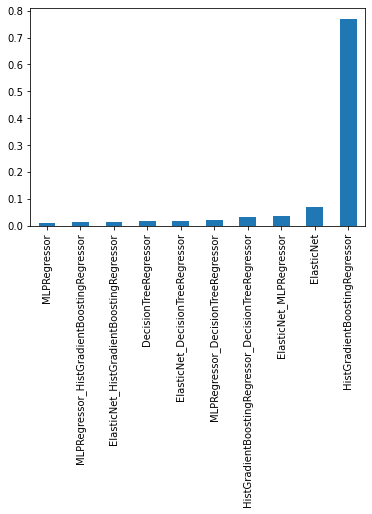

In [80]:
pd.Series(model_dict[model_name].best_estimator_.feature_importances_,x.columns).sort_values().plot(kind='bar')

## Submissions output

In [92]:
key = "HistGradientBoostingRegressor"
test = df_2[df_2['target'].isna()].drop('target',axis=1)
model = model_dict[key].best_estimator_
submissions = pd.DataFrame(model.predict(lvl2_scalerX.transform(test)),columns=['target'],index=test.index)
submissions.reset_index(inplace=True)
submissions.to_csv(f'submissions/{key}.csv',index=False)

In [93]:
submissions

,id,target
0,0,8.098475
1,2,7.668374
2,6,7.937966
3,7,8.149052
4,10,8.034140
...,...,...
199995,499984,7.924132
199996,499985,8.047434
199997,499987,8.106754
199998,499988,7.960806
